# **Smart-UJ UAQUE**
Este Notebook hace parte del servicio inteligente "perfil grupal" y tiene como objetivo la generación de clusters de usuarios a partir de el alquiler de ítems de la biblioteca Alfonso Borrero Cabal. Previamente se estrajeron los temas de cada ítem y en este notebook se generarán matrices dispersas que serán consumidad por el algoritmo de k-means para generar los clusters que posteriormente serán consumidos por los diferentes algoritmo de recomendación.

**Entrada**: Tabla_join.json

**Integrantes:**</br>
Johan Ortegón </br>
Juan Angarita </br>
Jorge Salgado </br>
Daniel Tibaquira </br></br>
**Directora de Proyecto de Grado:** </br>
Viky Arias </br>

# Importación de datos

Estas son las librerias que vamos a usar para hacer el join de ambas tablas y poder hacer las diferentes agrupaciones de estudiantes. 

* pandas(pd): Permite almacenar los datos en dataframes(matrices) y operación entre las celdas.
* KMeans: librería de sklearn para realizar el algoritmo de agrupamiento Kmeans.
* StandartScaler: Permite estandarizar los datos en una escala predeterminada.
* silhoute_score: permite sacar la métrica de puntaje de silhoute para los algoritmos de clustering.
* Normalizer: Permite normalizar los datos
* PCA: principal component analisis permite la reducción de dimensionalidad de nuestros dataset, en busca de que los algoritmos se ejecuten a mayor velocidad.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

Importamos el archivo. Este proviene del join entre las tablas de material bibliográfico de la biblioteca y la información de prestamos de la biblioteca. 

In [2]:
df = pd.read_json('https://www.dropbox.com/s/chk4h90xgm48adm/joinTablas.json?dl=1')
#df = pd.read_json('https://www.dropbox.com/s/c80i2zi3ba4a1lv/joinTablas-FEEDBACK.json?dl=1')

In [3]:
df.head(3)

,index,RowID,Fecha,IDItem,NumeroUbicacion,Dewey,Ubicacion,Llave,Programa,Facultad,...,Calificación,Signatura,TipoItem,Autor,Titulo,AnioPublicacion,DeweyEspecifico,TemaDewey,Temas,Union
0,0,Row0,1.547050e+12,80000005327627,720.98 A71S,720,COL-GRAL-2,866245,CARRERA DE ARQUITECTURA,arquitectura y diseño,...,NaN,720,LIBRO,"Arango Cardinal, Silvia 1948-",Ciudad y arquitectura seis generaciones que co...,2012.0,720.98,Arquitectura latinoamericana,"[arquitectur, histori, amer, latin]",arquitectur histori amer latin
1,1,Row1,1.547050e+12,80000001191496,720.9861 A71,720,COL-GRAL-2,309945,CARRERA DE ARQUITECTURA,arquitectura y diseño,...,NaN,720,LIBRO,"Arango Cardinal, Silvia 1948-",Historia de la arquitectura en Colombia Silvia...,1993.0,720.9861,Arquitectura colombiana,"[arquitectur, colonial, histori, colombi]",arquitectur colonial histori colombi
2,2,Row2,1.547139e+12,80000004979759,540 CH15Q 2010,540,COL-GRAL-3,822727,CARRERA DE ARQUITECTURA,arquitectura y diseño,...,NaN,540,LIBRO,"Chang, Raymond",Química Raymond Chang ; revisión técnica Rosa ...,2010.0,540,Química,[quimic],quimic


Anotamos la estructura del archivo. 

In [4]:
print("Numero de filas:", df.shape[0])
print("Numero de columnas:", df.shape[1])

Numero de filas: 490474
Numero de columnas: 22


El clustering para este experimento se realizará sobre el atributo "Signatura" el cual representa el dewey hasta la unidad (dando aproximadamente 900 deweys diferentes). Recordar la diferencia entre la columna "Dewey" y "Signatura". La primera es la que originalmente contiene el dataset de prestamos y solo venía con valores hasta la decena, mientras que "Sginatura" originalmente era una valor que señalaba el dewey especifico del libro y su ubicación al interior de la biblioteca. Se realizo una transformación para obtener únicamente el valor númerico de este valor y así obtener el dewey hasta la unidad(más especifico).

In [5]:
eliminar = df.loc[df["Signatura"].isnull()]
print("Numero de datos sin Dewey(Singatura):" , eliminar.shape[0])

Numero de datos sin Dewey(Singatura): 0


In [6]:
print("Valores de signatura unicos: " , len(df["Signatura"].unique()))
print("Valores de Dewey(decena) unicos: " , len(df["Dewey"].unique()))

Valores de signatura unicos:  756
Valores de Dewey(decena) unicos:  100


A partir del análisis con expertos en negocio, se ha entendido que es importante tomar en cuenta el cambio de gustos de los usuarios a través del tiempo y dar menos peso a prestamos que se realizaron en el pasado a prestamos más recientes. Para esto se creará una nueva columna denominada "Peso" la cual determinará el peso quue tiene dicho prestamo.
La disminución del peso será exponencial según la diferencia con el año actual y se calculará con la siguiente formula:

$Peso = \frac{1}{2^{(2021-20xx)}}$


In [7]:
def pesos(x):
    peso = 1/2**(2021-x.Year) 
    #if x["Calificación"] == -1:
    #    peso = peso*-1
    return peso

In [8]:
df["Peso"] = df.apply(lambda row: pesos(row) , axis=1 )

Se creará una nueva tabla donde únicamente se van a tener en cuenta los deweys que le gustan a cada usuario así como los atributos para posteriormente realizar el clustering. 

In [9]:
def positivo(x):
    if x<0:
        return 0
    else:
        return x

In [10]:
df.loc[df.IDUsuario == "9f0c701f95e6699463a28d15c29aea813d110c4e"].Peso.sum()

342.5

In [11]:
pesos_usuarios = pd.DataFrame(columns= df["Signatura"].unique(),dtype=float)
tam = len(df["Signatura"].unique())
pesos_usuarios.columns = pesos_usuarios.columns.astype(str)
display(pesos_usuarios)

ids = df["IDUsuario"].unique()
i = 0
for usuario in ids:
  pesos_usuarios.loc[i] = np.zeros((tam,), dtype=int)
  #Para cada usuario traer sus Deweys y sus pesas asociados
  prestamos = df.loc[df["IDUsuario"]==usuario]
  deweys = prestamos[["Signatura","Peso"]]
  result_user = deweys.groupby("Signatura")["Peso"].sum().reset_index(name="Peso")
  result_user.Peso = result_user.Peso.apply(lambda x: positivo(x))
  # Recorrer los Deweys y Pesos para plasmarlos en una matriz
  #display(result_user)
  for index, row in result_user.iterrows():
    d = row["Signatura"]
    p = row['Peso']
    pesos_usuarios[d][i] = p
  i = i+1

,720,540,512,712,741,814,823,330,863,696,...,267,114,034,673,447,600,653,263,091,586


La matriz generada es una matriz dispersa donde todos los valores son ceros excepto donde el usuario haya realizado un prestamo.

In [12]:
pesos_usuarios

,720,540,512,712,741,814,823,330,863,696,...,267,114,034,673,447,600,653,263,091,586
0,2.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125
1,0.00,1.0,1.25,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
2,0.00,0.0,0.00,3.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
3,0.25,0.0,0.00,0.000,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
4,5.00,0.0,0.00,0.875,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24402,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
24403,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
24404,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
24405,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000


In [13]:
#aux = pesos_usuarios[["720","710"]]
#aux = aux.drop(aux[(aux["720"] == 0) & (aux["710"] == 0)].index)
#aux

# Configuración Modelos
A partir del archivo "Comparación modelos" se puede concluir que el modelo que ayuda en mayor medida a agrupar los datos, minimizando el número de clusters con tamaño menor a 20 y la desviación estandar es kmeans con los siguiente parámetros:
* Filas normalizadas = true
* Columnas normalizadas = true
* PCA = 0.95
* Número de clusters = 150
* Número de iteraciones = 500

In [14]:
resumen = pd.DataFrame(columns = ["Tecnica","PCA", "Norm_filas", "Norm_col", "Precision", "Desviacion_estandar", "Media", "Coeficiente_variacion", "Clusters","Grupo_mas_grande", "Grupos<10", "Grupos<20"])


In [15]:
def std_dev_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.std(sizes_labels)

In [16]:
def mean_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.mean(sizes_labels)

In [17]:
#
PCA = 0.95
num_clusters = 2400
num_iter = 10

# Algoritmo kmeans

In [127]:
final = pesos_usuarios
#final = aux

In [128]:
sumatoria = final.sum(axis=1)
pesos_norm = final.div(sumatoria, axis=0).fillna(0)
pesos_norm

,720,540,512,712,741,814,823,330,863,696,...,267,114,034,673,447,600,653,263,091,586
0,0.380952,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02381
1,0.000000,0.181818,0.227273,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,0.285714,0.000000,0.000000,0.000000,0.285714,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,0.350877,0.000000,0.000000,0.061404,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24402,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
24403,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
24404,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
24405,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [163]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pesos_norm = pca.fit_transform(pesos_norm)
print(pca.n_components_)

137


In [164]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusterer.fit(pesos_norm)


HDBSCAN(min_cluster_size=10)

In [165]:
print(np.count_nonzero(clusterer.labels_ == -1))
print(max(clusterer.labels_))
clusterer.labels_ == -1
#clusterer.labels_

15880
186


array([ True,  True, False, ..., False,  True, False])

#Normalización
#2.5 min por iteración
sumatoria = final.sum(axis=1)
pesos_norm = final.div(sumatoria, axis=0).fillna(0)

#scaler = MinMaxScaler()
#pesos_norm = scaler.fit_transform(pesos_norm.values)

  #Kmeans
k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = num_iter)
k_means.fit_predict(pesos_norm)
labels = k_means.labels_

In [207]:
#Desempeño
#3 min
pres = silhouette_score(pesos_norm, labels)
print("silhouette_score: ", pres)

silhouette_score:  0.3328026376157128


In [140]:
grouped = df.groupby("IDUsuario")["Peso"].sum().reset_index(name="Peso")
grouped

,IDUsuario,Peso
0,00063d52cf68c65d2a569e95c40345c4a305ccc7,0.500
1,0006b3bdabeaa5389b211c8487bd67d339c97ef7,0.500
2,000a0630c32a437052696f6921e3181f155291d0,0.500
3,000c040064aedd76057c5309064a3823db970644,0.125
4,000f23e62e6d4995ede7090c6447ad6736edc4de,1.500
...,...,...
24402,fff71390a9f54ced5134452870d70ff18812f05f,2.125
24403,fff716c9685b5267e6ecfcdc00e9303509355bc1,1.000
24404,fff735f54719b720fc4c6c723208ad1f06e9605e,14.500
24405,fffb2be68fef4b27a810b11a641d84052eb02347,0.500


<AxesSubplot:>

NameError: name 'pres' is not defined

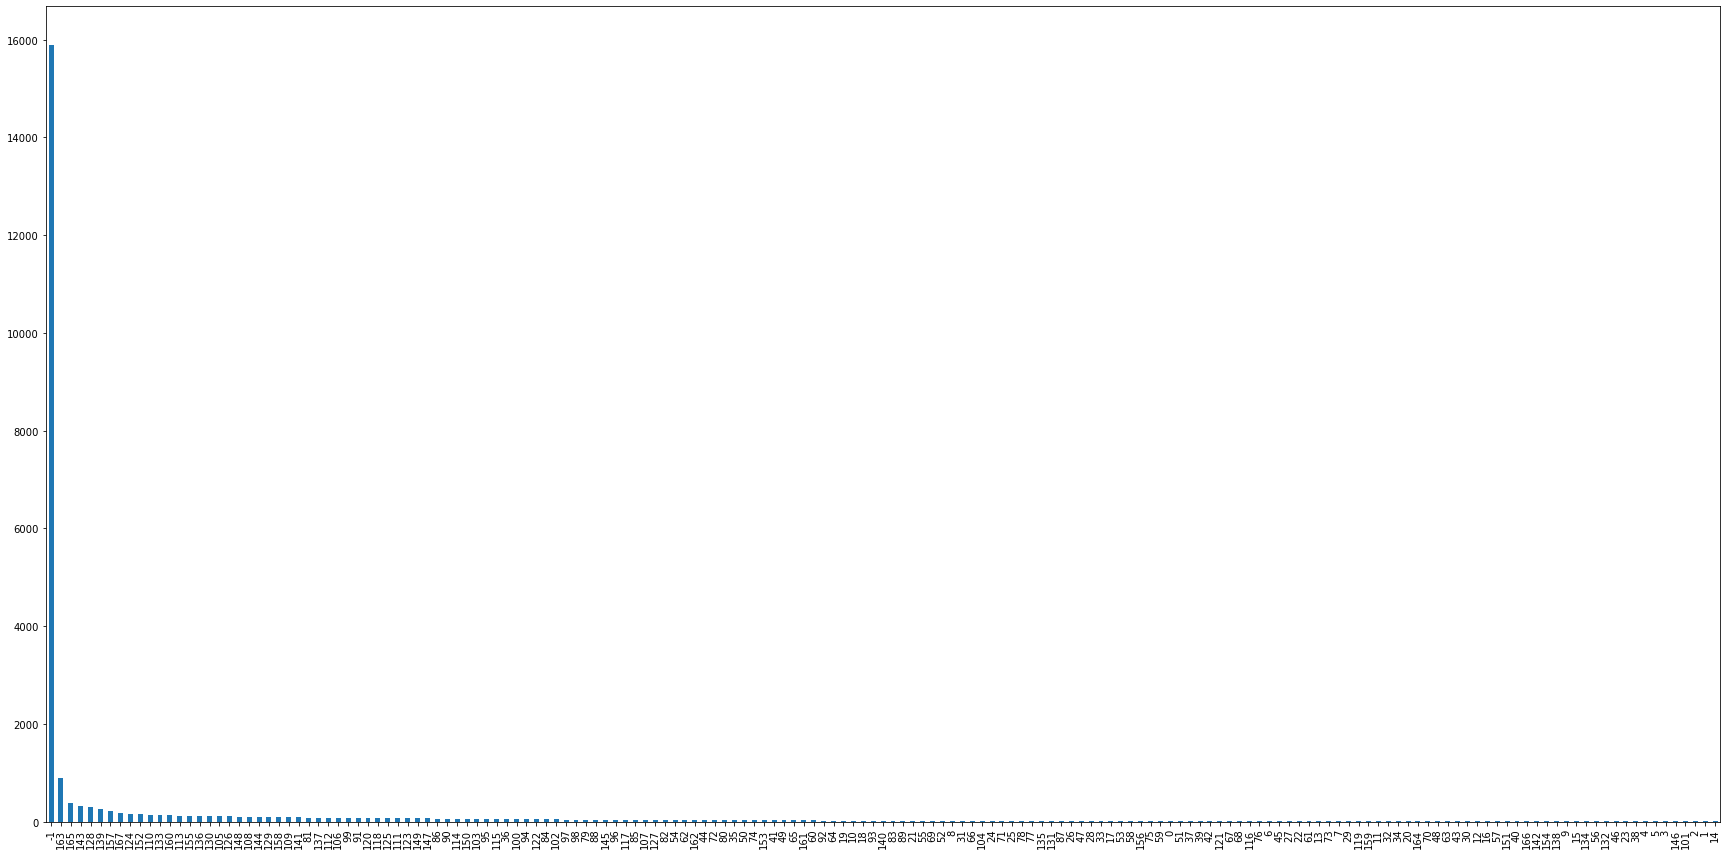

In [142]:
#copiamos el dataframe y agregamos los clusters para gráficar la distribución
labels = clusterer.labels_
df2 = final.copy()
df2["cluster"] = labels

#pegamos los cluster a la tabla que tiene los usuarios y los temas
df2["cluster"] = labels
display(df2["cluster"].value_counts().plot(kind='bar',figsize=(30,15)))


#Cálculo de métricas
media = mean_cluster(df2,labels)
desviacion = std_dev_cluster(df2,labels)
data = df2.groupby('cluster')['cluster'].count()
peque10 = len(data[data<=10])
peque20 = len(data[data<=20])
masGrande = data.max()
#Agregamos los datos a nuestra tabla de resumen para comparar
resumen = resumen.append({'Tecnica':"K-MEANS",
                              'PCA':0.95,
                              'Norm_filas':True,
                              'Norm_col':True,
                              'Precision':pres,
                              'Desviacion_estandar':desviacion,
                              'Media':media,
                              'Coeficiente_variacion':desviacion/media, 
                              'Clusters': num_clusters,
                              "Grupos<20":peque20,
                              "Grupos<10":peque10 , 
                              "Grupo_mas_grande":masGrande}, ignore_index=True)

In [186]:
grouped.head(3)

,IDUsuario,Peso
0,00063d52cf68c65d2a569e95c40345c4a305ccc7,0.5
1,0006b3bdabeaa5389b211c8487bd67d339c97ef7,0.5
2,000a0630c32a437052696f6921e3181f155291d0,0.5


In [201]:
resumen

,Tecnica,PCA,Norm_filas,Norm_col,Precision,Desviacion_estandar,Media,Coeficiente_variacion,Clusters,Grupo_mas_grande,Grupos<10,Grupos<20
0,K-MEANS,0.95,True,True,0.305846,50.932994,30.50875,1.669455,800,807,329,467
1,K-MEANS,0.95,True,True,0.305846,50.932994,30.50875,1.669455,800,807,329,467
2,K-MEANS,0.95,True,True,0.305846,267.739119,152.54375,1.755163,160,2635,0,5


Podemos analizar los temas más importantes que tiene cada cluster. 

In [148]:
cluster = df2.loc[df2.cluster == 4]
aux=cluster.astype(bool).sum(axis=0)
df3 = aux[aux > 0]
df3.sort_values(ascending=False).head(20)

336        10
cluster    10
303         1
657         1
dtype: int64

In [145]:
grouped.loc[grouped.cluster == 1].sort_values(ascending=False, by="Peso").head(10)

AttributeError: 'DataFrame' object has no attribute 'cluster'

In [124]:
df.loc[df.Signatura == "749"].IDUsuario

1048      ff6cb24d5efcee61c0da71e05ed15fa11a7d14be
1921      b28e71eac7d30fc1bde0d5a063a64f40008e3548
1922      b28e71eac7d30fc1bde0d5a063a64f40008e3548
1923      b28e71eac7d30fc1bde0d5a063a64f40008e3548
1924      b28e71eac7d30fc1bde0d5a063a64f40008e3548
                            ...                   
466233    c3ecb61c240746bb41c0ffd5b87ec40c0dc26387
469167    9629b828e7b7785c71ec9ff68124586401af981b
469168    9629b828e7b7785c71ec9ff68124586401af981b
469169    9629b828e7b7785c71ec9ff68124586401af981b
490261    20b2369b3c1b95d09e13f1e0cba2e1358ac75427
Name: IDUsuario, Length: 100, dtype: object

In [69]:
grouped.head(3)

,IDUsuario,Peso,cluster
0,00063d52cf68c65d2a569e95c40345c4a305ccc7,0.5,26
1,0006b3bdabeaa5389b211c8487bd67d339c97ef7,0.5,152
2,000a0630c32a437052696f6921e3181f155291d0,0.5,152


Pegamos la información del cluster a cada uno de los prestamos de los usuarios.(temas_usuarios_cluster)

In [70]:
material_data = pd.DataFrame(data=df)
cluster_data = pd.DataFrame(data=grouped)
temas_usuarios_cluster = pd.merge(material_data, cluster_data, left_on='IDUsuario', right_on='IDUsuario', how='left')
temas_usuarios_cluster.head(3)

,RowID,Fecha,IDItem,NumeroUbicacion,Dewey,Ubicacion,Llave,Programa,Facultad,IDUsuario,...,Autor,Titulo,AnioPublicacion,DeweyEspecifico,TemaDewey,Temas,Union,Peso_x,Peso_y,cluster
0,Row0,1547050497000,80000005327627,720.98 A71S,720,COL-GRAL-2,866245,CARRERA DE ARQUITECTURA,arquitectura y diseño,c361c772cd0220bb16dcfb2ad803e4903334ab94,...,"Arango Cardinal, Silvia 1948-",Ciudad y arquitectura seis generaciones que co...,2012.0,720.98,Arquitectura latinoamericana,"[arquitectur, histori, amer, latin]",arquitectur histori amer latin,0.25,5.25,3
1,Row1,1547050500000,80000001191496,720.9861 A71,720,COL-GRAL-2,309945,CARRERA DE ARQUITECTURA,arquitectura y diseño,c361c772cd0220bb16dcfb2ad803e4903334ab94,...,"Arango Cardinal, Silvia 1948-",Historia de la arquitectura en Colombia Silvia...,1993.0,720.9861,Arquitectura colombiana,"[arquitectur, colonial, histori, colombi]",arquitectur colonial histori colombi,0.25,5.25,3
2,Row2,1547138763000,80000004979759,540 CH15Q 2010,540,COL-GRAL-3,822727,CARRERA DE ARQUITECTURA,arquitectura y diseño,87b0e5a61ed712ddfaf5d478ad68c87c825997e9,...,"Chang, Raymond",Química Raymond Chang ; revisión técnica Rosa ...,2010.0,540,Química,[quimic],quimic,0.25,5.50,37


Crearemos un tercer dataframe el cual contega únicamente la información de cada cluster(sus centroides). 

In [71]:
centroids = pd.DataFrame(data = k_means.cluster_centers_)

In [72]:
centroids.columns = df["Signatura"].unique()
centroids

,720,540,512,712,741,814,823,330,863,696,...,267,114,034,673,447,600,653,263,091,586
0,2.035799e-03,7.155497e-04,1.570531e-03,7.379286e-04,2.920040e-03,2.475238e-04,0.004656,9.844200e-03,0.014945,-7.589415e-19,...,-2.710505e-20,-2.032879e-20,0.000000e+00,-2.710505e-20,-4.065758e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20
1,1.582028e-04,-1.951564e-18,-9.974660e-18,-6.505213e-19,1.240860e-04,-1.301043e-18,0.000221,9.889029e-04,0.000079,-3.252607e-19,...,-2.710505e-20,-2.710505e-20,4.065758e-20,-2.710505e-20,-3.388132e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20
2,5.204170e-18,2.416667e-03,9.090909e-04,-6.505213e-19,-8.673617e-18,-2.168404e-19,0.000227,-6.938894e-18,0.001000,-2.168404e-19,...,-2.710505e-20,-1.355253e-20,0.000000e+00,-2.710505e-20,-3.388132e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20
3,6.938894e-18,3.443526e-04,2.705628e-04,-6.505213e-19,-8.673617e-18,-2.168404e-19,0.002177,6.149154e-04,0.940848,-3.252607e-19,...,-2.710505e-20,-6.776264e-21,-2.710505e-20,-2.710505e-20,-3.388132e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20,-2.710505e-20
4,7.288630e-04,1.084202e-18,-2.602085e-18,-4.336809e-19,8.503401e-04,2.125850e-03,0.025095,3.093369e-03,0.009198,4.336809e-19,...,4.065758e-20,1.355253e-20,-5.421011e-20,4.065758e-20,2.032879e-20,4.065758e-20,4.065758e-20,4.065758e-20,4.065758e-20,4.065758e-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.000000e+00,-2.168404e-19,5.002319e-03,-2.168404e-19,-1.734723e-18,0.000000e+00,0.002849,0.000000e+00,0.000785,0.000000e+00,...,0.000000e+00,-6.776264e-21,1.355253e-20,0.000000e+00,-6.776264e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
156,1.560002e-04,3.092146e-03,8.673617e-19,-6.505213e-19,1.443001e-03,1.633587e-04,0.003247,-3.469447e-18,0.009502,-1.084202e-19,...,-1.355253e-20,-6.776264e-21,1.355253e-20,-1.355253e-20,-2.032879e-20,-1.355253e-20,-1.355253e-20,-1.355253e-20,-1.355253e-20,-1.355253e-20
157,1.600000e-02,-2.168404e-19,0.000000e+00,0.000000e+00,-1.734723e-18,2.168404e-19,0.000000,-3.469447e-18,0.000000,1.084202e-19,...,0.000000e+00,-1.355253e-20,1.355253e-20,0.000000e+00,-6.776264e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
158,2.012882e-04,2.436647e-04,9.025472e-03,-4.336809e-19,2.974549e-03,1.361656e-04,0.004667,5.609247e-03,0.017301,0.000000e+00,...,0.000000e+00,2.032879e-20,-2.710505e-20,0.000000e+00,-6.776264e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [73]:
centroids[centroids<1e-5] = 0

Finalmente exportamos las tablas para ser consumidas por los sistemas de recomedación junto al dashboard.
* Grouped_temas = usuarios + cluster
* temas_usuarios_cluster = joinTablas + cluster
* Centroids_deweys = clusters + centroides

In [74]:
grouped.to_json(r'/Users/juansebastianangaritatorres/Downloads/userCluster.json')

In [75]:
temas_usuarios_cluster.to_json(r'/Users/juansebastianangaritatorres/Downloads/joinCluster.json')

In [76]:
centroids.to_json(r'/Users/juansebastianangaritatorres/Downloads/centroids.json')